In [1]:
# import module
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [2]:
%whos

Variable      Type      Data/Info
---------------------------------
F             module    <module 'torch.nn.functio<...>/torch/nn/functional.py'>
nn            module    <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np            module    <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
optim         module    <module 'torch.optim' fro<...>torch/optim/__init__.py'>
os            module    <module 'os' from '/Users<...>rch/lib/python3.7/os.py'>
plt           module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sys           module    <module 'sys' (built-in)>
torch         module    <module 'torch' from '/Us<...>kages/torch/__init__.py'>
torchvision   module    <module 'torchvision' fro<...>torchvision/__init__.py'>
transforms    module    <module 'torchvision.tran<...>/transforms/__init__.py'>


In [3]:
# processdata

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5))])

# datasets
data_path='./datasets/fashion'
trainsets = torchvision.datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
testsets = torchvision.datasets.FashionMNIST(data_path, download=True, train=False, transform=transform)

# dataloader
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=4, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testsets, batch_size=4, shuffle=False, num_workers=2)

# constant of class
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

classes_zh = ('T恤', '裤子', '套头衫', '连衣裙', '大衣', '凉鞋', '衬衫', '运动鞋', '包', '裸靴')

torch.Size([1, 28, 28])


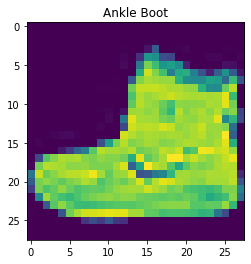

In [4]:
# 从 trainsets 中取出一张图，通过 pylot 观察
image, label = trainsets[0]
print(image.shape)
fig = plt.figure()
image = image.numpy().transpose((1,2,0))
ax = plt.subplot(1,1,1)
ax.set_title(classes[label])
plt.imshow(image)


In [5]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        # 灰度处理，将 channel 维度压缩，求三个通道均值
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# TensorBoard 设置
1. 如果想使用 tensorboard，得提前使用 pip 将 tensorboard 安装到运行环境中。  
2. 然后在通过 import torch.utils.tensorboard 进行导入。
3. 定义 SumaryWriter() 对象

In [8]:
%pip install tensorboard -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torch.utils.tensorboard import SummaryWriter

log_dir = './log/fashion_mnist_experiment_1'
writer = SummaryWriter('log/fashion_mnist_experiment_1')

# 写入 TensorBoard
使用 make_grid 将图像写入到 TensorBoard 中

torch.Size([4, 1, 28, 28])
torch.Size([3, 32, 122])


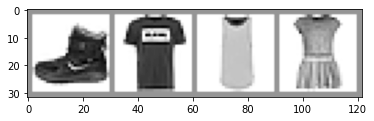

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
# create grid of images
img_grid = torchvision.utils.make_grid(images)

print(img_grid.shape)
# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

# 启动 tensorboard web ui

In [18]:
!tensorboard --logdir=log

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# 使用 TensorBoard 检查模型
TensorBoard 的优势之一是其可视化复杂模型结构的能力

In [11]:
writer.add_graph(net, images)
writer.close()

# 在 TensorBoard 中添加一个“投影仪”
在低维空间中可视化高维数据

In [12]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    # 打乱顺序的 torch.tensor 数组, 从 0 ~ len(data)
    perm = torch.randperm(len(data))
    # 返回乱序后的前 n 个数据
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainsets.data, trainsets.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

print("images shape: {}".format(images.shape))
# log embeddings
features = images.view(-1, 28 * 28)
print("features shape: {}".format(features.shape))
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

images shape: torch.Size([100, 28, 28])
features shape: torch.Size([100, 784])


# 使用 TensorBoard 跟踪模型训练

In [16]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # 同 preds = preds_tensor.squeeze()
    preds = np.squeeze(preds_tensor.numpy())
    # 通过 softmax 将 output 转成对应下标分类的概率
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

# Training
在迭代训练的时候，边输出到 tensorboard

In [17]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


# Torch.mean
沿着矩阵某一维度，求元素求均值。
经常出现的场景：将图片的 channel 维度压缩，彩色图片变成灰度图片。例如：  
rgb_img = torch.randn(3, 32, 32)
img = torch.mean(rgb_img, dim=0)

In [ ]:
# torch.mean()

x=torch.arange(27.0).view(3, 3, 3)
# 沿着 dim 进行挤压
x_mean=torch.mean(x,dim=0,keepdim=True)
x_mean0=torch.mean(x,dim=1,keepdim=True)
print('before bn:')
print("x size:", x.shape)
print("x:", x)
print('x_mean size:', x_mean.shape)
print('x_mean:', x_mean)
print('x_mean0 size:', x_mean0.shape)
print('x_mean0:', x_mean0)
